# Learning Curve To Identify Overfit & Underfit

## Table of Contents
***

1. Overfitting and Underfitting Refresher
2. Modeling (Iris data) using Logistic Regression
3. Identifying and handling Multicollinearity using VIF
4. Introduction to Learning Curve
5. Learning Curve of a Good Fit Model
6. Learning Curve of an Overfit Model
7. Learning Curve of an Underfit Model

***

## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold, cross_val_score, learning_curve, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.pipeline import Pipeline
import random
from statsmodels.stats.outliers_influence import variance_inflation_factor
from IPython.display import Image

## Overfitting and Underfitting Refresher

### Overfitting (aka Variance):
A model is said to be overfit if the model is overtrained on the data such that it even learns the noise from the data. In the figure below, the third image shows overfitting where the model has learnt each and every example so perfectly that it misclassifies an unseen/new example. For a model that's overfit we have a perfect/close to perfect training set score while a poor test/validation score.

### Reasons for overfitting
1. Using a complex model for a simple problem which picks up the noise from the data. Example: Using a neural network on Iris dataset
2. Small datasets, as the training set may not be a right representation of the universe

### Underfitting (aka Bias):
A model is said to be underfit if the model is unable to learn the patterns in the data properly. In the figure below, the first image shows overfitting where the model hasn't fully learnt each and every example. In such cases we see a low score on both the training set and test/validation set

### Reasons for underfitting
1. Using a simple model for a complex problem which doesn't pick up all the patterns from the data. Example: Using a logistic regression for image classification
2. The underlying data has no inherent pattern. Example, trying to predict a student's marks with his father's weight.

![overfitting.jpg](../../../../images/ml-advanced/model-selection/overfitting_1.jpg)
> Image Source: [https://www.geeksforgeeks.org/underfitting-and-overfitting-in-machine-learning/]( https://www.geeksforgeeks.org/underfitting-and-overfitting-in-machine-learning/)

## Modeling (Iris data) using Logistic Regression

In this section we'll fit a LogisticRegressor to the Iris dataset and identify underfitting, overfitting and good fit.

In [11]:
#Data Import
train = pd.read_csv("../../../assets/data/Iris-model-selection.csv")
train.head()

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,Iris-setosa
1,2,4.9,3.0,1.4,0.2,Iris-setosa
2,3,4.7,3.2,1.3,0.2,Iris-setosa
3,4,4.6,3.1,1.5,0.2,Iris-setosa
4,5,5.0,3.6,1.4,0.2,Iris-setosa


In [12]:
#Shuffling the data since the labels are arranged in an order
random.seed(11)
train = train.iloc[random.sample(range(len(train)),len(train))].reset_index(drop=True)
train

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,116,6.4,3.2,5.3,2.3,Iris-virginica
1,144,6.8,3.2,5.9,2.3,Iris-virginica
2,120,6.0,2.2,5.0,1.5,Iris-virginica
3,150,5.9,3.0,5.1,1.8,Iris-virginica
4,131,7.4,2.8,6.1,1.9,Iris-virginica
...,...,...,...,...,...,...
145,125,6.7,3.3,5.7,2.1,Iris-virginica
146,121,6.9,3.2,5.7,2.3,Iris-virginica
147,83,5.8,2.7,3.9,1.2,Iris-versicolor
148,63,6.0,2.2,4.0,1.0,Iris-versicolor


In [13]:
#Dataset is small so using a complex model may lead to overfitting, so we considered LogisticRegressor as it's a pretty simple model
train.shape

(150, 6)

In [14]:
# All the data types look good
train.dtypes 

Id                 int64
SepalLengthCm    float64
SepalWidthCm     float64
PetalLengthCm    float64
PetalWidthCm     float64
Species           object
dtype: object

In [15]:
train.describe(include="all")

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
count,150.000000,150.000000,150.000000,150.000000,150.000000,150
unique,NaN,NaN,NaN,NaN,NaN,3
top,NaN,NaN,NaN,NaN,NaN,Iris-virginica
freq,NaN,NaN,NaN,NaN,NaN,50
mean,75.500000,5.843333,3.054000,3.758667,1.198667,NaN
std,43.445368,0.828066,0.433594,1.764420,0.763161,NaN
min,1.000000,4.300000,2.000000,1.000000,0.100000,NaN
25%,38.250000,5.100000,2.800000,1.600000,0.300000,NaN
50%,75.500000,5.800000,3.000000,4.350000,1.300000,NaN
75%,112.750000,6.400000,3.300000,5.100000,1.800000,NaN


In [16]:
np.round(train.isnull().mean(),2)*10

Id               0.0
SepalLengthCm    0.0
SepalWidthCm     0.0
PetalLengthCm    0.0
PetalWidthCm     0.0
Species          0.0
dtype: float64

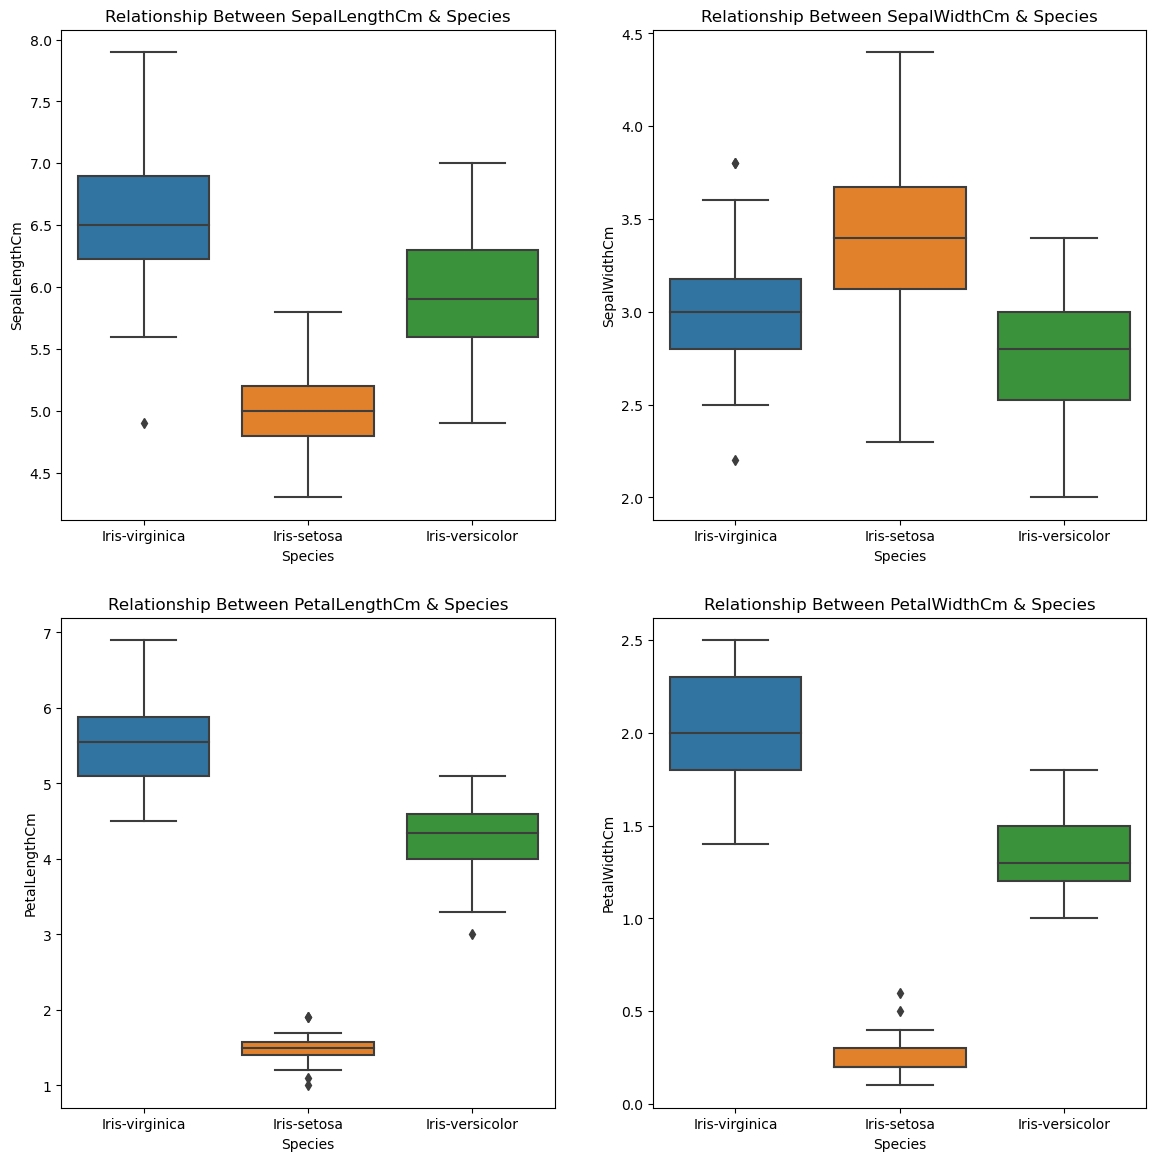

In [17]:
r = c = 0
fig,ax = plt.subplots(2,2,figsize=(14,14))
for n,i in enumerate(train.columns[1:-1]):
    sns.boxplot(x="Species",y=i,data=train,ax=ax[r,c])
    ax[r,c].set_title(f"Relationship Between {i} & Species")
    c += 1
    if (n+1)%2==0:
        c = 0
        r += 1
plt.show()

**There exists a strong relationship between target and input features**

In [18]:
#Splitting the data into input and target features
X = train.iloc[:,1:-1].copy()
y = train.iloc[:,-1]

In [19]:
# Input features
X

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm
0,6.4,3.2,5.3,2.3
1,6.8,3.2,5.9,2.3
2,6.0,2.2,5.0,1.5
3,5.9,3.0,5.1,1.8
4,7.4,2.8,6.1,1.9
...,...,...,...,...
145,6.7,3.3,5.7,2.1
146,6.9,3.2,5.7,2.3
147,5.8,2.7,3.9,1.2
148,6.0,2.2,4.0,1.0


In [20]:
#Target feature. Should LabelEncode this
y 

0       Iris-virginica
1       Iris-virginica
2       Iris-virginica
3       Iris-virginica
4       Iris-virginica
            ...       
145     Iris-virginica
146     Iris-virginica
147    Iris-versicolor
148    Iris-versicolor
149        Iris-setosa
Name: Species, Length: 150, dtype: object

In [21]:
#Well balanced dataset
y.value_counts() 

Iris-virginica     50
Iris-setosa        50
Iris-versicolor    50
Name: Species, dtype: int64

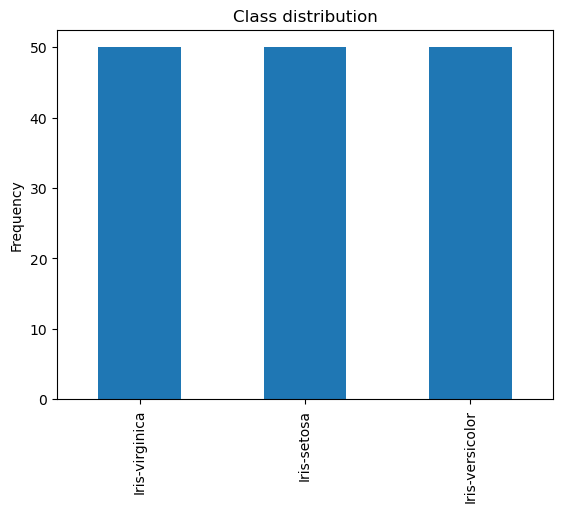

In [22]:
y.value_counts().plot(kind="bar")
plt.title("Class distribution")
plt.ylabel("Frequency");

## Identifying and handling Multicollinearity using VIF

The correlation matrix below shows high multicollinearity among input features. VIF > 5 or 10 implies multicollinearity.

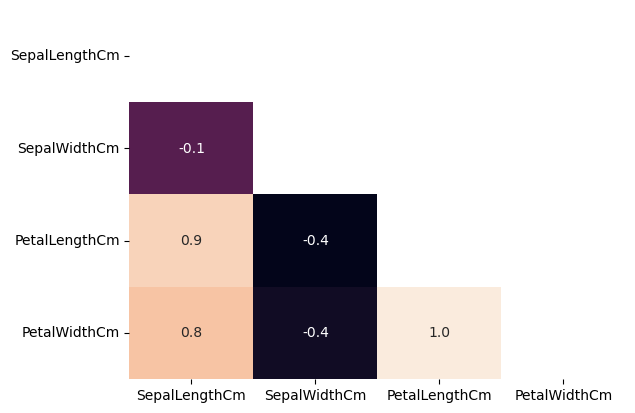

In [23]:
sns.heatmap(X.corr(),annot=True,fmt="0.1f",cbar=False,mask=np.triu(X.corr()));

In [24]:
X_vif  = X.copy()
vif =  [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
print(vif)

[264.7457109493044, 97.1116058338033, 173.96896536339727, 55.48868864572551]


In [25]:
#removing first feature
X_vif = X_vif.iloc[:,1:].copy()

In [26]:
vif =  [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
print(vif)

[5.896727335512334, 61.750178363923474, 42.917554018630476]


In [27]:
#Removing 2nd feature
X_vif = X_vif.iloc[:,[0,2]].copy()

In [28]:
#No multicollinearity
vif =  [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
print(vif)

[2.8977517768607695, 2.8977517768607695]


For this notebook, we're ignoring multicollinearity as we're unable to overfit the model (since we're reduced the number of input features). So, we're considering all the input features for this problem.

In [ ]:
#The function below builds the model and returns cross validation scores, train score and learning curve data
def learn_curve(X,y,c):
    ''' param X: Matrix of input features
        param y: Vector of Target/Label
        c: Inverse Regularization variable to control overfitting (high value causes overfitting, low value causes underfitting)
    '''
    '''We aren't splitting the data into train and test because we will use StratifiedKFoldCV.
       KFold CV is a preffered metho compared to hold out CV, since the model is tested on all the examples.
       Hold out CV is preferred when the model takes too long to train and we have a huge test set that truly represents the universe
    '''
    
    le = LabelEncoder() # Label encoding the target
    sc = StandardScaler() # Scaling the input features
    y = le.fit_transform(y)#Label Encoding the target
    
    log_reg = LogisticRegression(max_iter=200,random_state=11,C=c) # LogisticRegression model
    
    # Pipeline with scaling and classification as steps, must use a pipelne since we are using KFoldCV
    lr = Pipeline(steps=(['scaler',sc],
                        ['classifier',log_reg]))
    
    
    cv = StratifiedKFold(n_splits=5,random_state=11,shuffle=True) # Creating a StratifiedKFold object with 5 folds
    cv_scores = cross_val_score(lr,X,y,scoring="accuracy",cv=cv) # Storing the CV scores (accuracy) of each fold
    
    
    lr.fit(X,y) # Fitting the model

    train_score = lr.score(X,y) # Scoring the model on train set
    
    #Building the learning curve
    train_size,train_scores,test_scores = learning_curve(estimator=lr,X=X,y=y,cv=cv,scoring="accuracy",random_state=11)
    train_scores = 1-np.mean(train_scores,axis=1)#converting the accuracy score to misclassification rate
    test_scores = 1-np.mean(test_scores,axis=1)#converting the accuracy score to misclassification rate
    lc = pd.DataFrame({"Training_size":train_size,"Training_loss":train_scores,"Validation_loss":test_scores}).melt(id_vars="Training_size")
    return {"cv_scores":cv_scores,
           "train_score":train_score,
           "learning_curve":lc}

## Introduction to Learning Curve

Learning curve is a plot that plots the training and validation loss for a sample of training examples by incrementally increasing them. Learning curves helps us in identifying if adding additional training examples could improve the validation score or not. If a model is overfit then adding additional training examples might improve the model performance on unseen data. Similarly, if a model is underfit then adding training examples doesn't help

## Learning Curve of a Good Fit Model

Below we'll use the function created above to get a good fit model. We'll set the inverse regularization variable/parameter 'c' to 1 (i.e. we are not performing any regularization)

Cross Validation Accuracies:
-------------------------
[0.9666666666666667, 0.9, 0.9666666666666667, 0.9666666666666667, 1.0]

Mean Cross Validation Accuracy:
-------------------------
0.9600000000000002

Standard Deviation of Cross Validation Accuracy:
-------------------------
0.03265986323710903

Training Accuracy:
---------------
0.9733333333333334




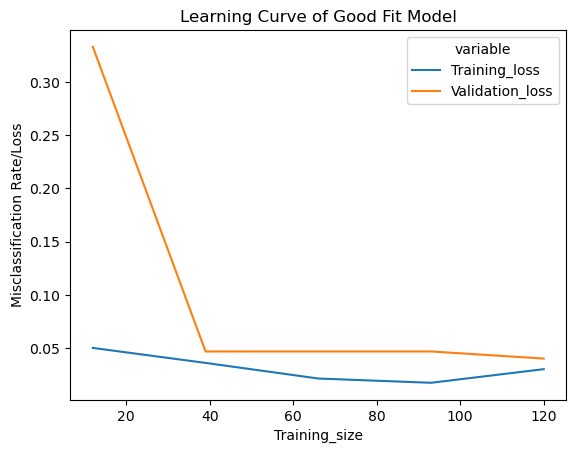

In [35]:
lc = learn_curve(X,y,1)
print(f'Cross Validation Accuracies:\n{"-"*25}\n{list(lc["cv_scores"])}\n\n\
Mean Cross Validation Accuracy:\n{"-"*25}\n{np.mean(lc["cv_scores"])}\n\n\
Standard Deviation of Cross Validation Accuracy:\n{"-"*25}\n{np.std(lc["cv_scores"])}\n\n\
Training Accuracy:\n{"-"*15}\n{lc["train_score"]}\n\n')
sns.lineplot(data=lc["learning_curve"],x="Training_size",y="value",hue="variable")
plt.title("Learning Curve of Good Fit Model")
plt.ylabel("Misclassification Rate/Loss");

The cross validation accuracy and training accuracy calculated above are close to each other
### Interpreting the training loss
Learning curve of a good fit model has a moderately high training loss at the beginning which gradually lowers upon adding training examples and flattens gradually indicating addition of more training examples doesn't improve the model performance on training data
### Interpreting the validation loss
Learning curve of a good fit model has a high validation loss at the beginning which gradually lowers upon adding training examples and flattens gradually indicating addition of more training examples doesn't improve the model performance on unseen data

We can also see that upon adding a reasonable number of training examples, both the training and validation loss are close to each other

**Typical Features**
* Train and Validation loss close to each other with validation loss > training loss.
* Initially reducing training and validation loss and a pretty flat training and validation loss after some poin

## Learning Curve of an Overfit Model

Below we'll use the function created above to get an overfit model. We'll set the inverse regularization variable/parameter 'c' to 10000 (high value of 'c' causes overfitting)

Cross Validation Accuracies:
-------------------------
[0.9666666666666667, 0.8666666666666667, 1.0, 1.0, 1.0]

Mean Cross Validation Accuracy:
-------------------------
0.9666666666666668

Standard Deviation of Cross Validation Accuracy:
-------------------------
0.05163977794943221 (High Variance)

Training Accuracy:
---------------
0.9866666666666667




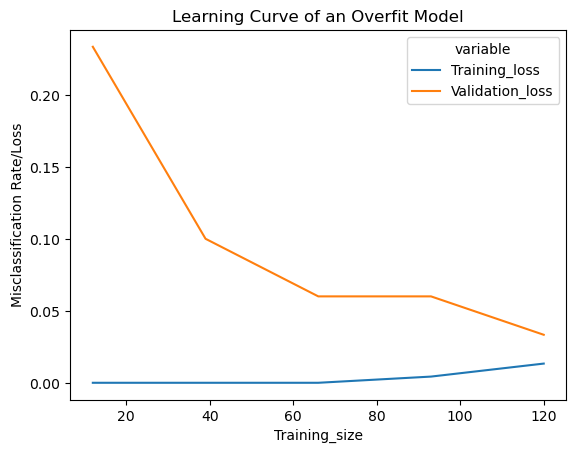

In [32]:
lc = learn_curve(X,y,10000)
print(f'Cross Validation Accuracies:\n{"-"*25}\n{list(lc["cv_scores"])}\n\n\
Mean Cross Validation Accuracy:\n{"-"*25}\n{np.mean(lc["cv_scores"])}\n\n\
Standard Deviation of Cross Validation Accuracy:\n{"-"*25}\n{np.std(lc["cv_scores"])} (High Variance)\n\n\
Training Accuracy:\n{"-"*15}\n{lc["train_score"]}\n\n')
sns.lineplot(data=lc["learning_curve"],x="Training_size",y="value",hue="variable")
plt.title("Learning Curve of an Overfit Model")
plt.ylabel("Misclassification Rate/Loss");

The standard deviation in cross validation accuracy is high compared to underfit and good fit model. Training accuracy is higher than cross validation accuracy, typical to an overfit model, but not too high to detect overfitting. But Overfitting can be detected from the learning curve.

### Interpreting the training loss
Learning curve of an overfit model has a very low training loss at the beginning which gradually increases very slightly upon adding training examples and doesn't flatten.

### Interpreting the validation loss
Learning curve of an overfit model has a high validation loss at the beginning which gradually lowers upon adding training examples and doesn't flatten, indicating addition of more training examples can improve the model performance on unseen data

We can also see that the training and validation losses are far away from each other, which may come close to each other upon adding additional training data

**Typical Features**
* Train and Validation loss far away from each other.
* Gradually decreasing validation loss (without flattening)
Very low training loss that's very slightly increasing

## Learning Curve of an Underfit Model

Below we'll use the function created above to get an underfit model. We'll set the inverse regularization variable/parameter 'c' to 1/10000 (low value of 'c' causes underfitting)

Cross Validation Accuracies:
-------------------------
[0.7666666666666667, 0.8, 0.8, 0.8, 0.7666666666666667]

Mean Cross Validation Accuracy:
-------------------------
0.7866666666666667

Standard Deviation of Cross Validation Accuracy:
-------------------------
0.01632993161855452 (Low variance)

Training Accuracy:
---------------
0.8133333333333334




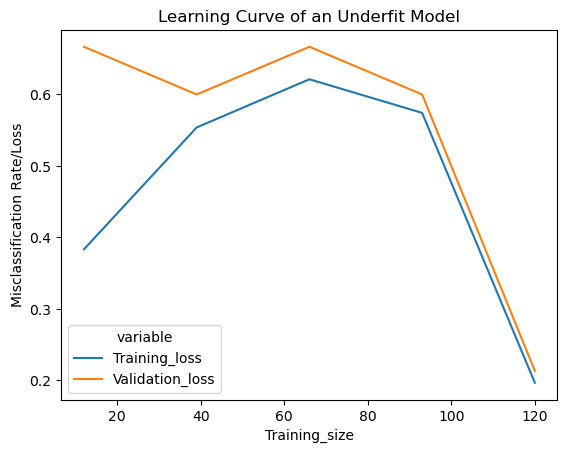

In [33]:
lc = learn_curve(X,y,1/10000)
print(f'Cross Validation Accuracies:\n{"-"*25}\n{list(lc["cv_scores"])}\n\n\
Mean Cross Validation Accuracy:\n{"-"*25}\n{np.mean(lc["cv_scores"])}\n\n\
Standard Deviation of Cross Validation Accuracy:\n{"-"*25}\n{np.std(lc["cv_scores"])} (Low variance)\n\n\
Training Accuracy:\n{"-"*15}\n{lc["train_score"]}\n\n')
sns.lineplot(data=lc["learning_curve"],x="Training_size",y="value",hue="variable")
plt.title("Learning Curve of an Underfit Model")
plt.ylabel("Misclassification Rate/Loss");

The standard deviation in cross validation accuracy is low compared to overfit and good fit model. Underfitting can be detected from the learning curve.

### Interpreting the training loss
Learning curve of an underfit model has a low training loss at the beginning which gradually increases upon adding training examples and suddenly falls to the minimum at the end.

### Interpreting the validation loss
Learning curve of an underfit model has a high validation loss at the beginning which gradually lowers upon adding training examples and suddenly falls to the minimum at the end, indicating addition of more training examples can't improve the model performance on unseen data

We can also see that the training and validation losses are very close to each other at the end. Adding additional training examples doesn't improve the performance on unseen data.

**Typical Features**
* Increasing Training Loss.
* Training and Validation Loss very close to each other at the end
Sudden dip in the training and validation losses at the end

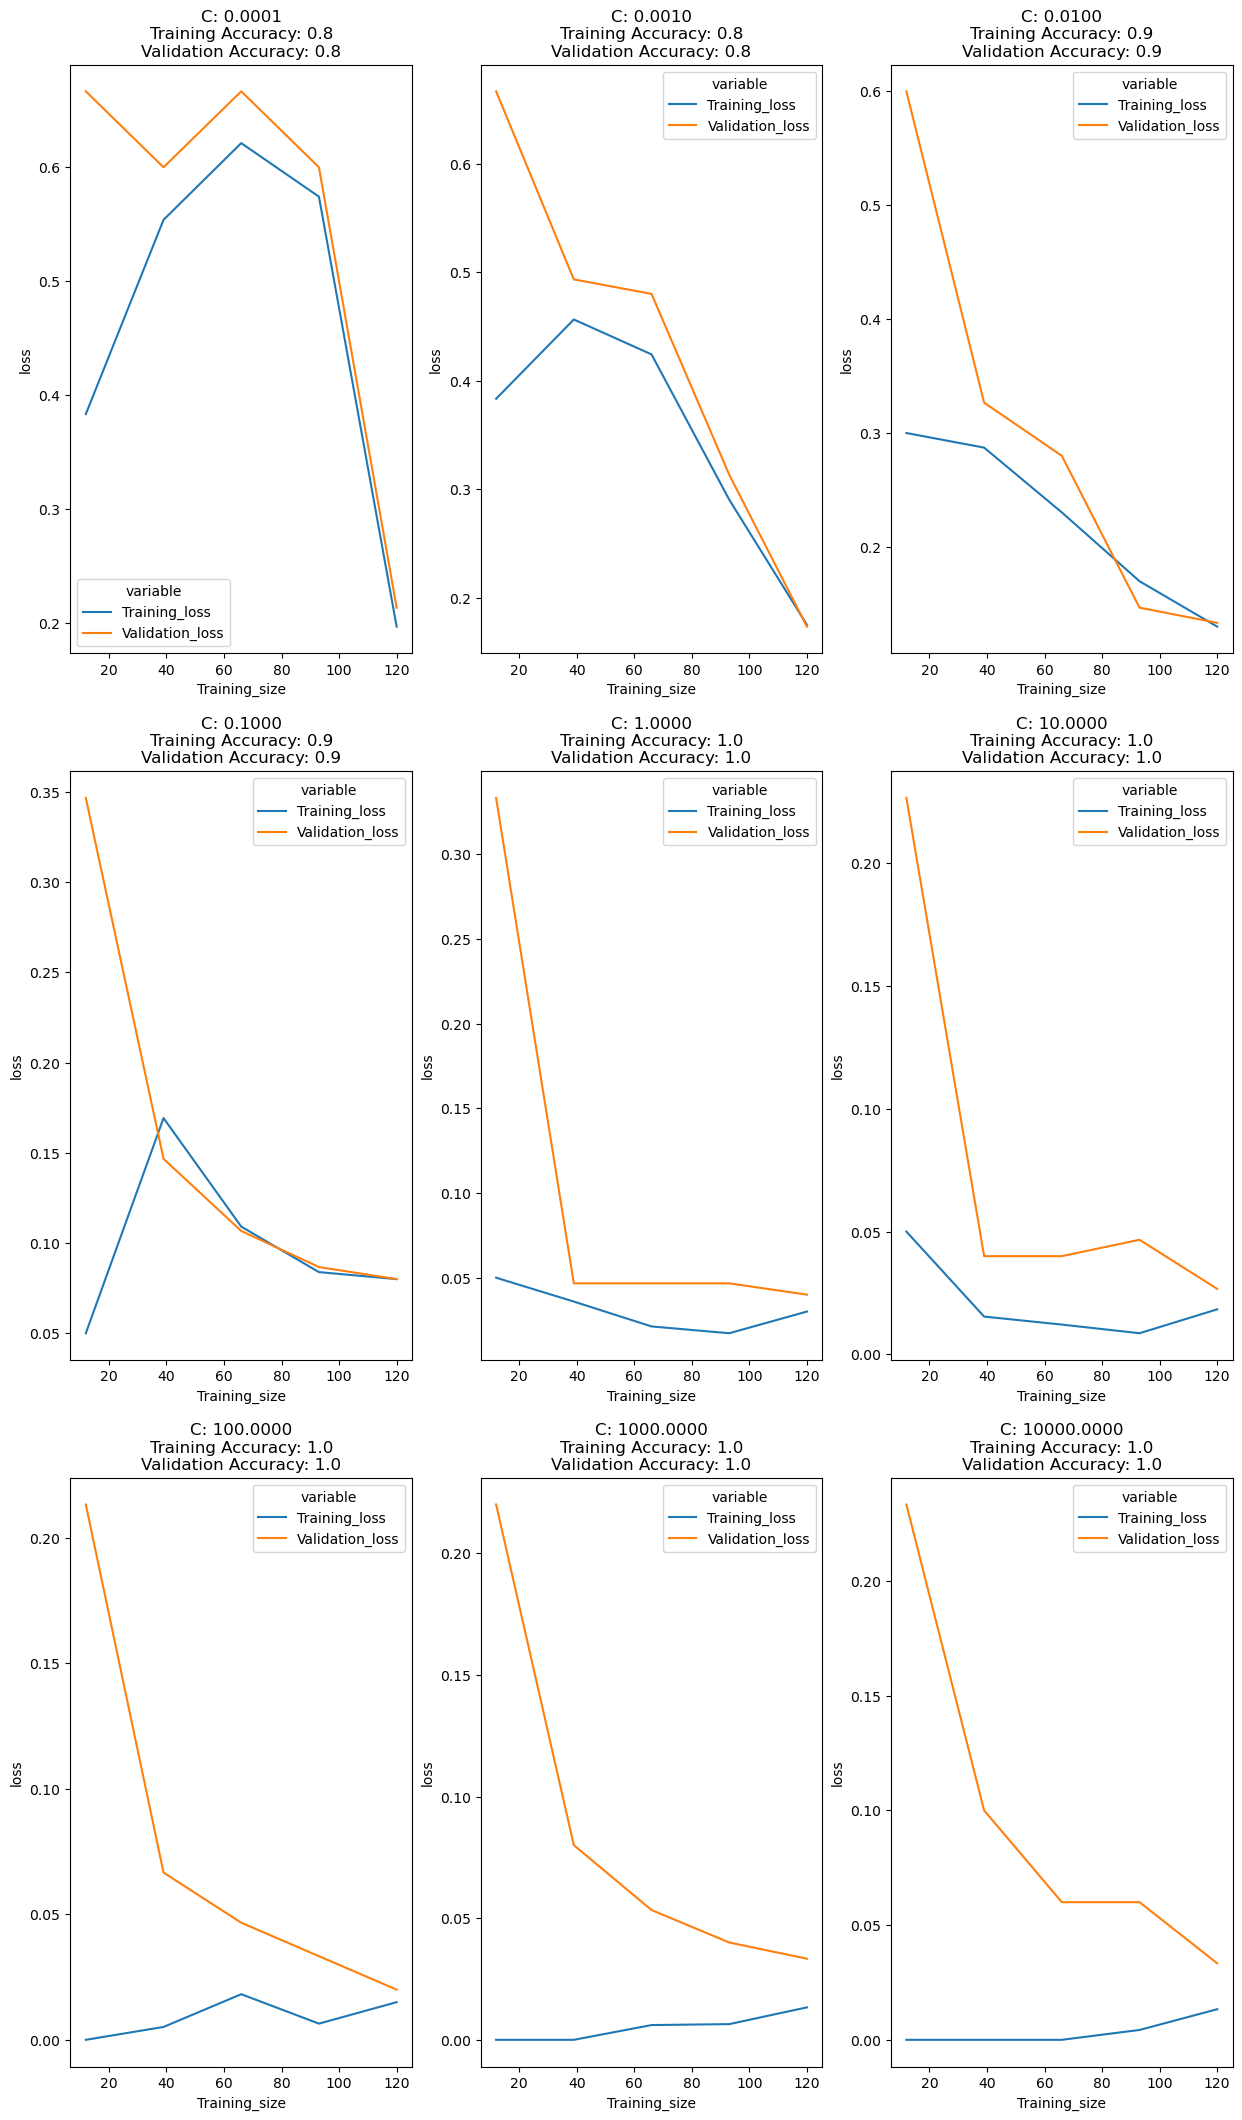

In [34]:
fig,ax = plt.subplots(3,3,figsize=(15,26))
r=c=0
for n,i in enumerate([0.0001,0.001,0.01,0.1,1,10,100,1000,10000]):
    lc = learn_curve(X,y,i)
    sns.lineplot(data=lc["learning_curve"],x="Training_size",y="value",hue="variable",ax=ax[r,c])
    ax[r,c].set_title(f'C: {i:.4f}\nTraining Accuracy: {lc["train_score"]:.1f}\nValidation Accuracy: {np.mean(lc["cv_scores"]):.1f}')
    ax[r,c].set_ylabel("loss")
    c+=1
    if (n+1)%3==0:
        c=0
        r += 1
plt.show()    

## Acknowledgments

Thanks to [KSV MURALIDHAR](https://www.kaggle.com/ksvmuralidhar) for creating the open-source course [Learning Curve To Identify Overfit & Underfit](https://www.kaggle.com/code/ksvmuralidhar/learning-curve-to-identify-overfit-underfit/notebook). It inspires the majority of the content in this chapter.